<a href="https://colab.research.google.com/github/skbetz54/Samuel_DATA606/blob/main/Notebooks/Article_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install contractions # used to get rid of contractions (in real-world news articles)
# !pip install textblob # used for quantifying polarity of the tweets in the dataset.
# !pip install newspaper3k

import pandas as pd
import lxml
from lxml.html import fromstring, tostring

# from newspaper import Article
# import newspaper
# import BeautifulSoup4 as bs4

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torchtext
import pickle
import torch

#Preprocessing Functions
from sklearn.utils import shuffle
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt') # punkt is a dependency used for nltk's  function "word_tokenize" that does not come when you import nltk
nltk.download('stopwords') # NLTK has a built-in dictionary of stop words that will be used when removing stopwords from the data
nltk.download('averaged_perceptron_tagger') # package that assigns parts of speech, to be used in lemmatization
nltk.download('wordnet') # Added because the above import from corpus sometimes does not work.
from nltk.tag import pos_tag # Another package used in lemmatization to import parts of speech for words

from wordcloud import WordCloud # EDA Tool
from textblob import TextBlob

from google.colab import files, drive

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
open_path_cnn = "/content/gdrive/MyDrive/DATA606/Data/df_cnn_0514.csv"
open_path_fn = "/content/gdrive/MyDrive/DATA606/Data/df_foxnews_0514.csv"

df_cnn = pd.read_csv(open_path_cnn)
df_fn = pd.read_csv(open_path_fn)

df_cnn =df_cnn.drop(columns='Unnamed: 0')
df_fn =df_fn.drop(columns='Unnamed: 0')

In [ ]:
df_cnn=df_cnn[['Title','lemma_string']]
df_fn=df_fn[['Title','lemma_string']]

df = pd.concat([df_cnn, df_fn], axis=0)

df = df.reset_index()

In [ ]:
df.head()

,index,Title,lemma_string
0,0,Opinion: It won't be long before extremists in...,julian zelizer cnn political analyst professor...
1,1,Michael Osterholm: Covid-19 keeps firing 210-m...,peter bergen cnn 's national security analyst ...
2,2,Opinion: Katie Porter's example reveals a pivo...,( cnn ) private meeting house democratic caucu...
3,3,Opinion: Why the baby formula shortage is so t...,syra madad dhsc msc mcp infectious disease epi...
4,4,Opinion: Trust in the Supreme Court is grievou...,barbara a. perry gerald l. baliles professor d...


In [ ]:
# Dictionary Creation

cnn_dict = {i:df_cnn.lemma_string for i in range(len(df_cnn))}
fn_dict = {i:df_fn.lemma_string for i in range(len(df_fn))}
full_dict ={i:df.lemma_string for i in range(len(df))}

In [ ]:
# Vocabulary Creation

import time

combined = df.lemma_string.str.cat(sep = " ")

t1 = time.perf_counter()

idx2word = {0:'PAD',1:'SOS',2:'EOS'}

for word in combined.split():
  if word not in idx2word.values():
    idx2word[len(idx2word)] = word

t2 = time.perf_counter()

print("\nTime to create vocabulary: %f seconds" %(t2-t1))
print("Length of Vocabulary: %d" %(len(idx2word)))

word2idx = {v: k for k, v in idx2word.items()}


Time to create vocabulary: 10.862478 seconds
Length of Vocabulary: 15594


In [ ]:
# Finally, now that we have our data loaded, we can create a tensor object that can be passed into the model to be tested

  
#Splitting our string into individual vectors and creating a new column to be used below.
 
df['vector'] = df.lemma_string.apply(lambda x: str(x.split(sep =" ")))
df['vector_length'] = df.vector.apply(lambda x: len(x))


length = max(df.vector_length)


# Finally, creating a mapper using the above vocabulary to assign values to each nonblank sentence.
for position, vector in enumerate(df['vector']):
  
  # Creating an empty Pytorch tensor to be used in the model predictions
  sentence_vector  = torch.zeros(((df['vector_length'][position])), dtype=torch.long)

  # Running through each individual vector
  for index, word in enumerate(vector): 

    sentence_vector[index] = word2idx[word]
  df['tensor'] = sentence_vector

## **Model Loading**

In [ ]:
# Instantiating the rnn that will be used with the state dict in the next cell to make predictions

D = 64 
vocab_size = len(idx2word)
hidden_nodes = 256 
classes = 6

lossfunc = nn.CrossEntropyLoss()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model_best = = nn.Sequential(
    nn.Embedding(vocab_size, D),
    nn.RNN(D, hidden_nodes, batch_first = True),
    LastTimeStep(),
    nn.Linear(hidden_nodes, classes)
)

In [ ]:
# Loading the best model created in the previous notebook it's state dictionary from after training.

statedictpath = r"/content/gdrive/My Drive/DATA606/BasicModels/BestModel/model_best.pt"

loader = torch.load(statedictpath)

loader2 = loader['model_state_dict']

model_best.load_state_dict(loader2)

## **Testing**

Now that our trained model is loaded, all we have to do is predict on each sample.


In [ ]:
# Creating a helper dictionary to transform the emotions into numbers (and vice versa)

emotion = ["Fear", "Anger", "Sadness","Joy","Love","Surprise"]

num_to_emotion = {i:emotion[i] for i in range(len(emotion))}
emotion_to_letter = {emotion[i]:i for i in range(len(emotion))}

print(emotion_to_letter)

{'Fear': 0, 'Anger': 1, 'Sadness': 2, 'Joy': 3, 'Love': 4, 'Surprise': 5}


In [ ]:
# Creating a function to predict each individual article

def predict(location, model):
  # Running the input (in this case, a dataframe's row) through the model
  prediction = model(location)
  # Transforming the output into a a softmax function
  prediction = F.softmax(prediction, dim=1) 
  # Getting the index of the max output from the softmax function, which is the class with the highest probability
  output = prediction[0].index(max(prediction[0])) 
  # Using the previous helper function to get the emotion assigned to each integer 
  output = num_to_emotion(output)
  return output

In [ ]:
# Creating a new column that predicts each input value

df['prediction'] = df['tensor'].apply(lambda x: predict(x, model_best))

df['sentiment'] = df['lemma_string'].apply(lambda x: TextBlob(x).sentiment.polarity)

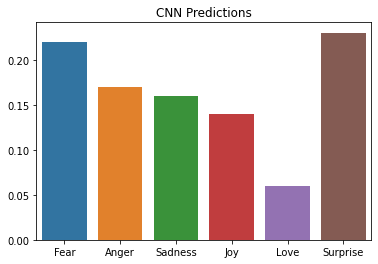

In [ ]:
# CNN Output

df_sub = df.loc[df['Site'] == 'Cnn']

len = len(df_sub)

cnn_results = df_sub['prediction'].value_counts()

plt.title("CNN Predictions")
sns.barplot(x=emotion,y=cnn_results/len)
plt.show()

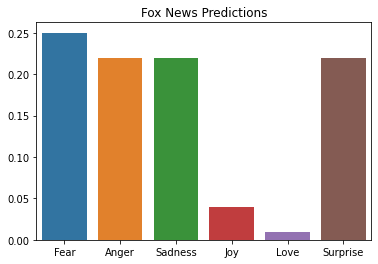

In [ ]:
# Fox News Output
df_sub = df.loc[df['Site'] == 'Fox'] 

len = len(df_sub)

fn_results = df_sub['prediction'].value_counts()

plt.title("Fox News Predictions")
sns.barplot(x=emotion,y=fn_results/len)
plt.show()

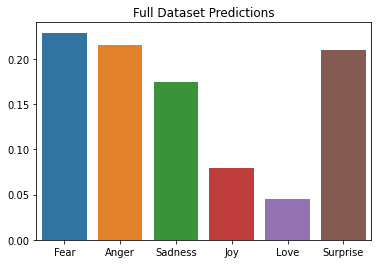

In [ ]:
# Full Dataset Output

full_results = df[['prediction']].value_counts()

len = len(df)

plt.title("Full Dataset Predictions")
sns.barplot(x=emotion,y=full_results/len)
plt.show()

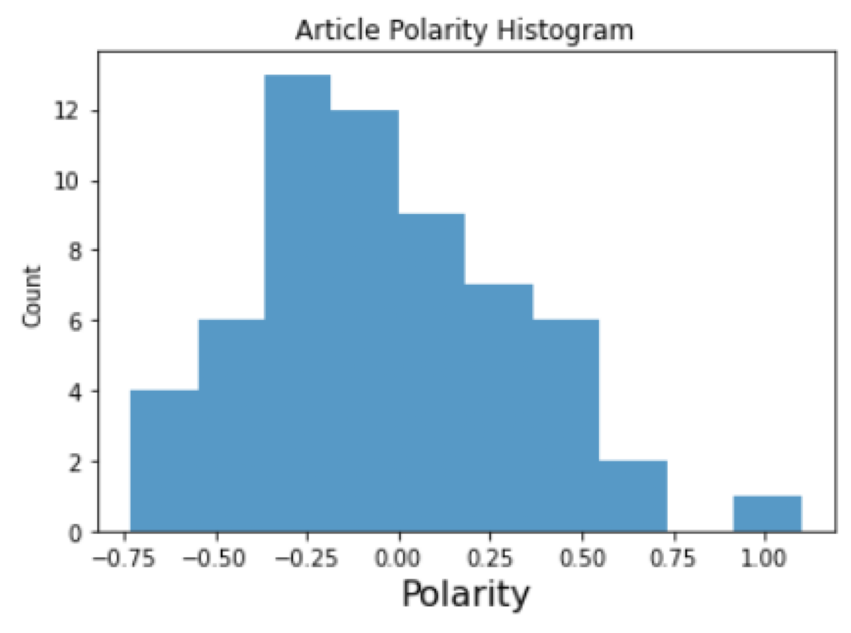

In [ ]:
# Creating a histogram of the polarity of the articles


plt.figure(figsize=(15,15))
plt.title("Article Polarity Histogram")
sns.histplot(df['sentiment'],bins=10)
plt.show()